In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM, BraninCurrin
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cpu"),
}

In [3]:
# define problem
# problem = BraninCurrin(negate=True).to(**tkwargs)
problem = GMM(negate=True).to(**tkwargs)
problem.ref_point = torch.tensor([0., 0.], **tkwargs)

## Problem

The approximated pareto set and pareto front is shown in the following figure.

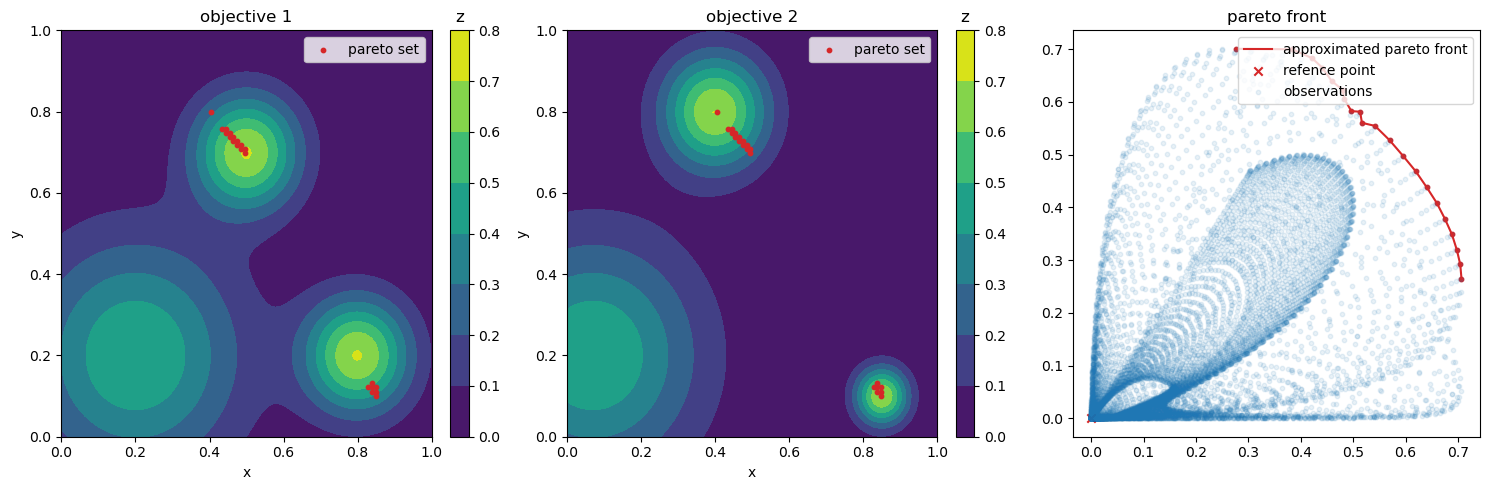

In [4]:
from plot_utils import plot_objective

plot_objective(problem, num_samples=100)

In [5]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

In [6]:
init_x, init_y = generate_initial_data(problem, n=100)

## Pareto dominance

**For Maximization**: an objective vector $\mathbf f(\mathbf x)$ Pareto-dominates $\mathbf f (\mathbf x′)$, denoted as $\mathbf f(\mathbf x) \succ \mathbf f(\mathbf x')$, if $f^{(m)}(x) \geq f^{(m)}(x′)$ for all $m = 1, \dots, M$ and there exists at least one $m \in \{1, . . . , M\}$ such that $f^{(m)}(x) > f^{(m)}(x′)$.

## Modeling the objective space

A classifier answers a question that whether the objective value $y$ outperform a certain fraction of point: $\hat \pi(\mathbf x) = p(y \geq \tau \mid \mathbf x)$.

We try to model the separately model the objectives via BORE (PI). For a bi-objective case we have: $$\hat \pi^1 (\mathbf x) = p(y^1 \geq \tau^1 \mid \mathbf x)$$ $$ \hat \pi^2 (\mathbf x) = p(y^2 \geq \tau^2 \mid \mathbf x)\,.$$
Assuming the objectives are independent: $$ p(y^1 \geq \tau^1, y^2 \geq \tau^2 \mid \mathbf x) = p(y^1 \geq \tau^1 \mid \mathbf x) \cdot p(y^1 \geq \tau^1 \mid \mathbf x)\,. $$
In this case, this convert to determine whether $\mathbf f(\mathbf x)$ weakly dominate a point $(\tau^1, \tau^2)$: $p(\mathbf f(\mathbf x) \succeq \bm \tau)$.

If we jointly model **BORE** with $\gamma$, we can dynamically vary the threshold $(\tau^m)^M_{m=1}$, which allowing us:
- Output the likelihood for different $\bm \tau$
- We can map the current observation to $\bm \tau$: $\bm \tau = \mathbf f(\mathbf x_i)$, and output likelihood that a given $\mathbf x$ outperforming an specific observation $\mathbf x_i$.

## Generate data

In [7]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import pygmo as pg

In [8]:
from optimizers.lfbo.lfbo_joint_rand import LFBO_JointRand
x_obs = init_x
y_obs = init_y

num_obj = problem.num_objectives
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.t()[0], 200
    ),
    np.linspace(
        *problem.bounds.t()[1], 200
    ),
)
x_cands = np.vstack((xx.flatten(), yy.flatten())).T
x_cands = torch.from_numpy(x_cands).to(**tkwargs)
y_cands = problem(x_cands).reshape(200, 200, num_obj)
xx_obj, yy_obj = y_cands[:, :, 0], y_cands[:, :, 1]

optimizer_list = []
for i in range(problem.num_objectives): 
    optimizer = LFBO_JointRand(input_dim=problem.bounds.shape[-1], output_dim=1, weight_type='pi', interpolation='lower', **tkwargs)
    optimizer.fit(x_obs, -y_obs[:, i:i+1], S=5000)
    optimizer_list.append(optimizer)

In [9]:
def plot_input_space(xx, yy, x_obs, preds, fig, ax, title=None):
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # plot functions
    countourset = ax.contourf(
        xx,
        yy,
        preds.reshape(xx.shape),
    )
    ax.scatter(*x_obs.t(), alpha=0.1, s=10, color='tab:red')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(title)
    clb.ax.set_title('z')


def plot_pareto_space(y_obs, pareto, l, u_nbd, ax, title='pareto'):
    ax.scatter(*y_obs[~pareto].t(), s=10, alpha=0.3)
    ax.scatter(*l.t(), s=10, color='tab:red', label="pareto")
    ax.plot(*l.t(), color='tab:red')
    ax.scatter(*u_nbd.t(), s=10, label="non dominated", color='tab:purple')
    ax.scatter(*problem.ref_point.t(), marker='x', s=10, label="ref point")

    ax.set_xlabel('y1')
    ax.set_ylabel('y2')
    ax.set_title(title)
    ax.legend()


def plot_pareto_box(tau, boxes, ax):
    ax.scatter(*tau.t(), label=r"$\mathbf{\tau}$")
    pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
    pc.set_array(torch.arange(0, len(boxes)))
    ax.add_collection(pc)
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    ax.axvspan(x_lim[0], tau[0], alpha=0.1, color='tab:gray')
    ax.axhspan(y_lim[0], tau[1], alpha=0.1, color='tab:gray')
    ax.set_xlim(*x_lim)
    ax.set_ylim(*y_lim)

## PI against a reference point

In [10]:
ndf, _, _, _ = pg.core.fast_non_dominated_sorting(-y_obs.numpy())
print(f"Number of pareto shell {len(ndf)}")

Number of pareto shell 31


In [11]:
num_obs = 0
for n, shell in enumerate(ndf, start=1):
    num_obs += len(shell)
    if num_obs / len(y_obs) > 1/10:
        break

shell_idx = n

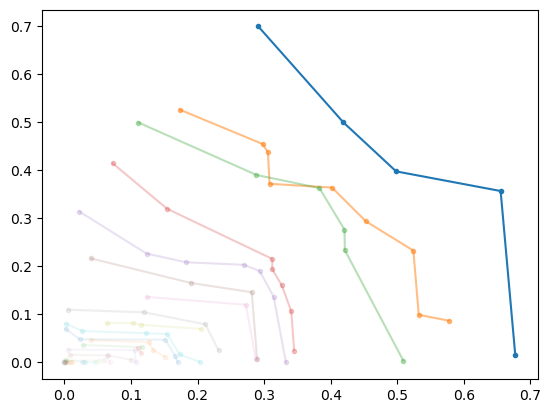

In [12]:
for n, shell in enumerate(ndf, start=1):
    sorted_idx = np.argsort(-y_obs.numpy()[shell][:, 0])
    plt.plot(
        y_obs.numpy()[shell][sorted_idx][:, 0],
        y_obs.numpy()[shell][sorted_idx][:, 1],
        '-o',
        markersize=3,
        alpha=1/n
    )

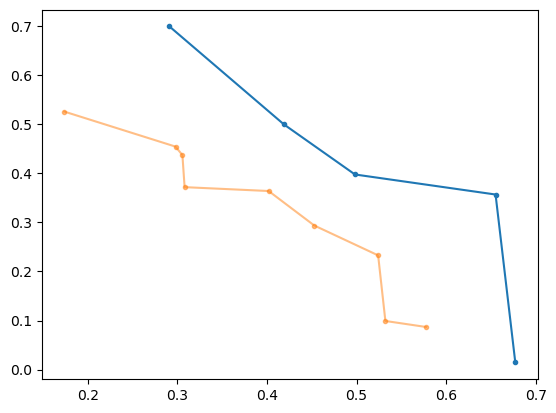

In [13]:
for n, shell in enumerate(ndf, start=1):
    sorted_idx = np.argsort(-y_obs.numpy()[shell][:, 0])
    plt.plot(
        y_obs.numpy()[shell][sorted_idx][:, 0],
        y_obs.numpy()[shell][sorted_idx][:, 1],
        '-o',
        markersize=3,
        alpha=1/n
    )
    if n == shell_idx:
        break

In [14]:
def get_partial_observations(y_obs, gamma, tkwargs):
    ndf, _, _, _ = pg.core.fast_non_dominated_sorting(-y_obs.numpy())
    print(f"Number of pareto shell {len(ndf)}")

    num_obs = 0
    for n, shell in enumerate(ndf, start=1):
        num_obs += len(shell)
        if num_obs / len(y_obs) > gamma:
            break
    shell_idx = n

    y_shell = torch.empty(0, y_obs.shape[-1], **tkwargs)
    for i in range(shell_idx, len(ndf), 1):
        y_shell = torch.cat((y_shell, y_obs[ndf[i].astype(int)]))

    return y_shell

Iteration 0
Number of pareto shell 31


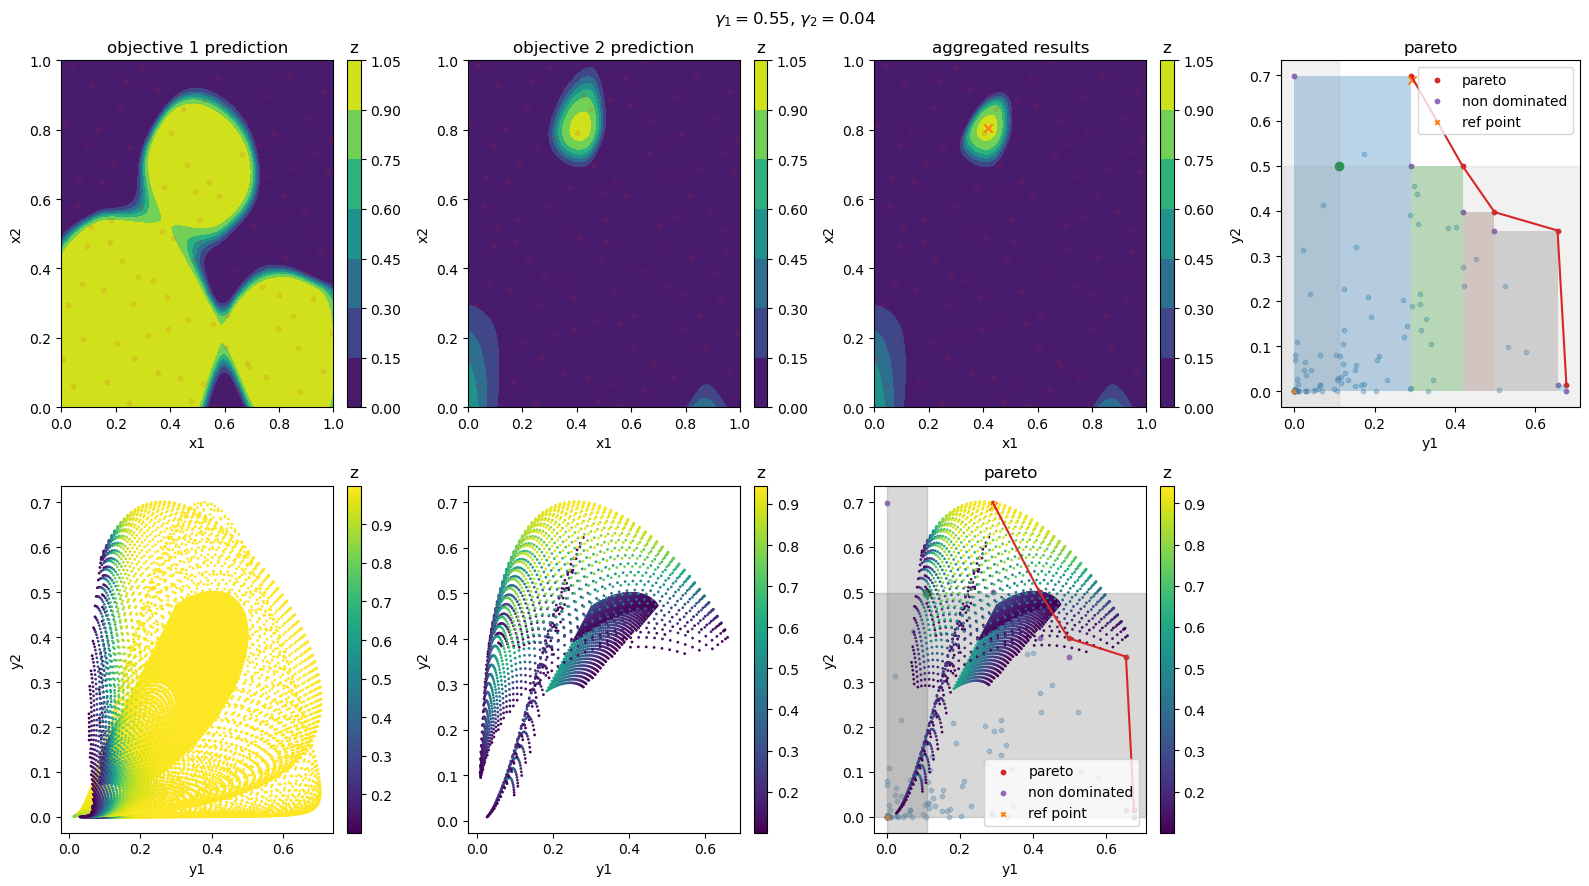

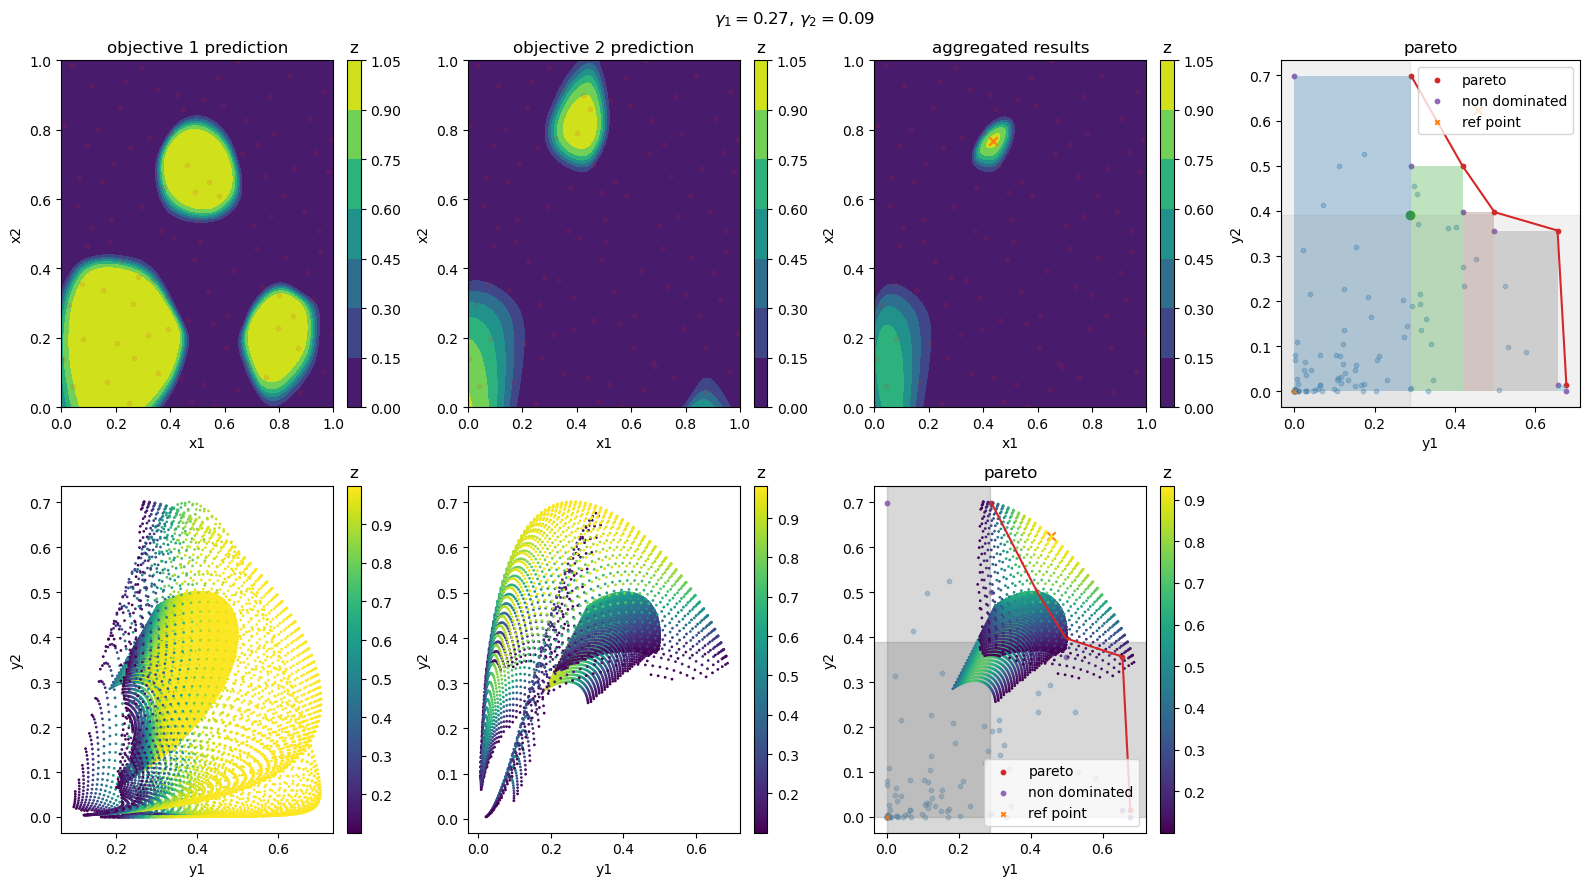

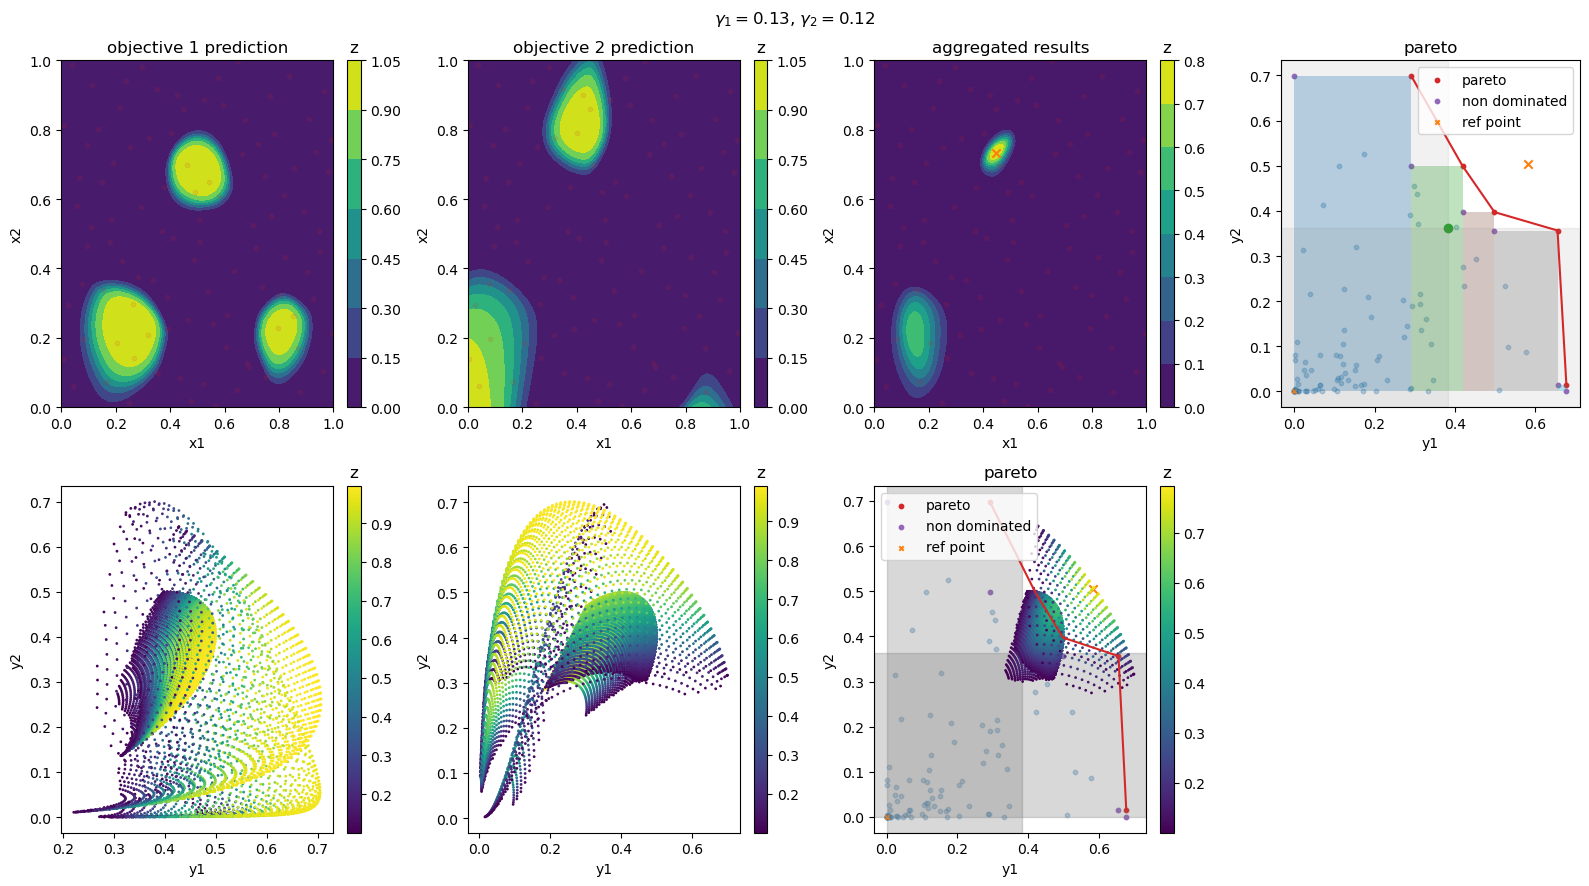

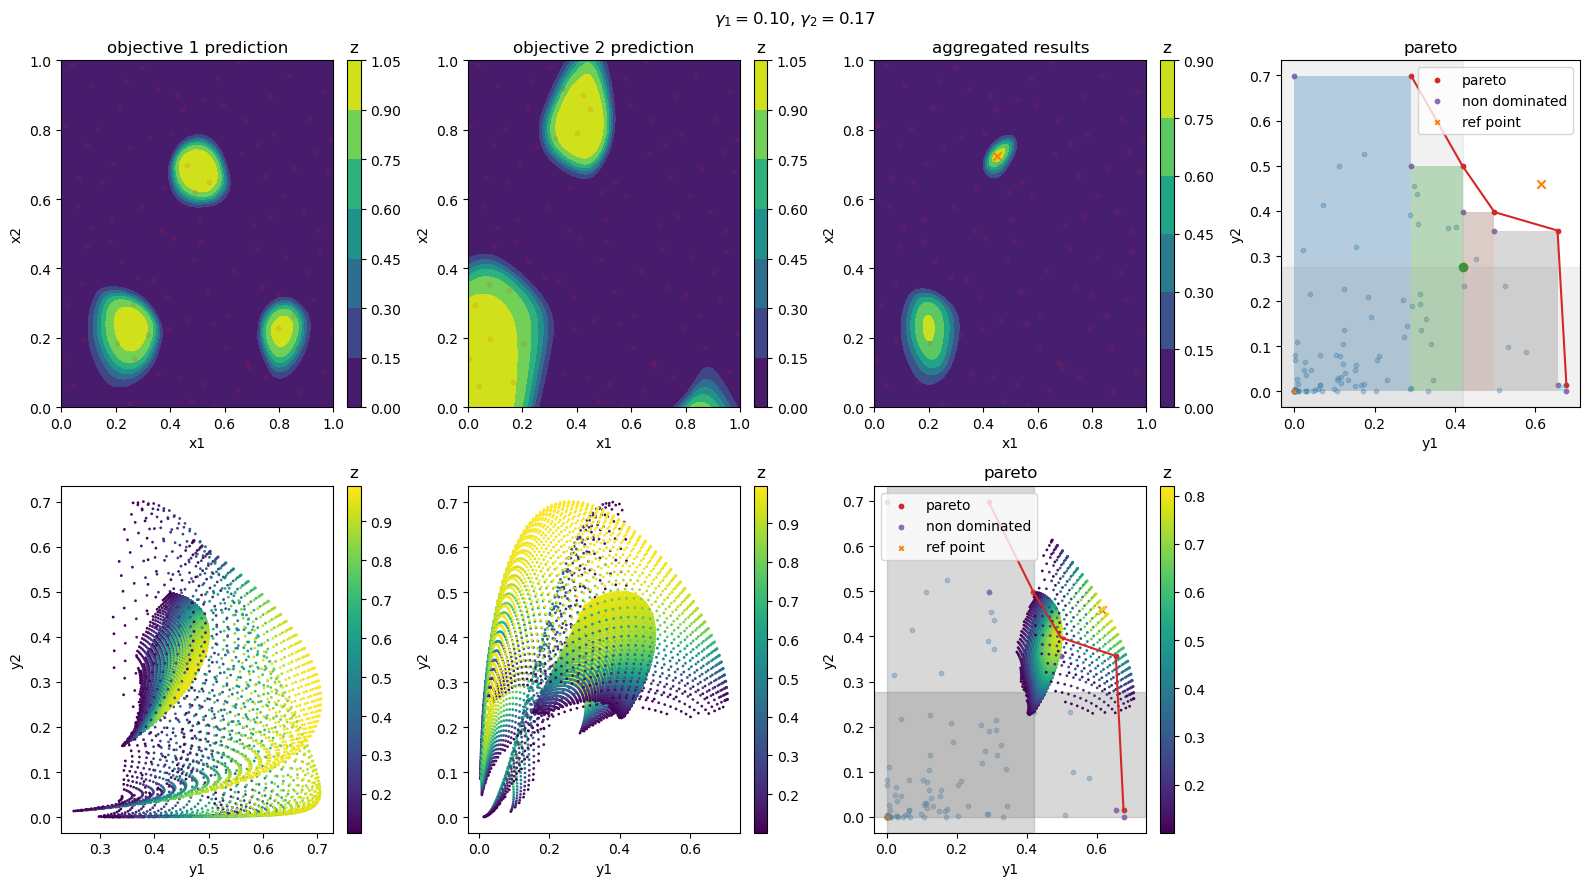

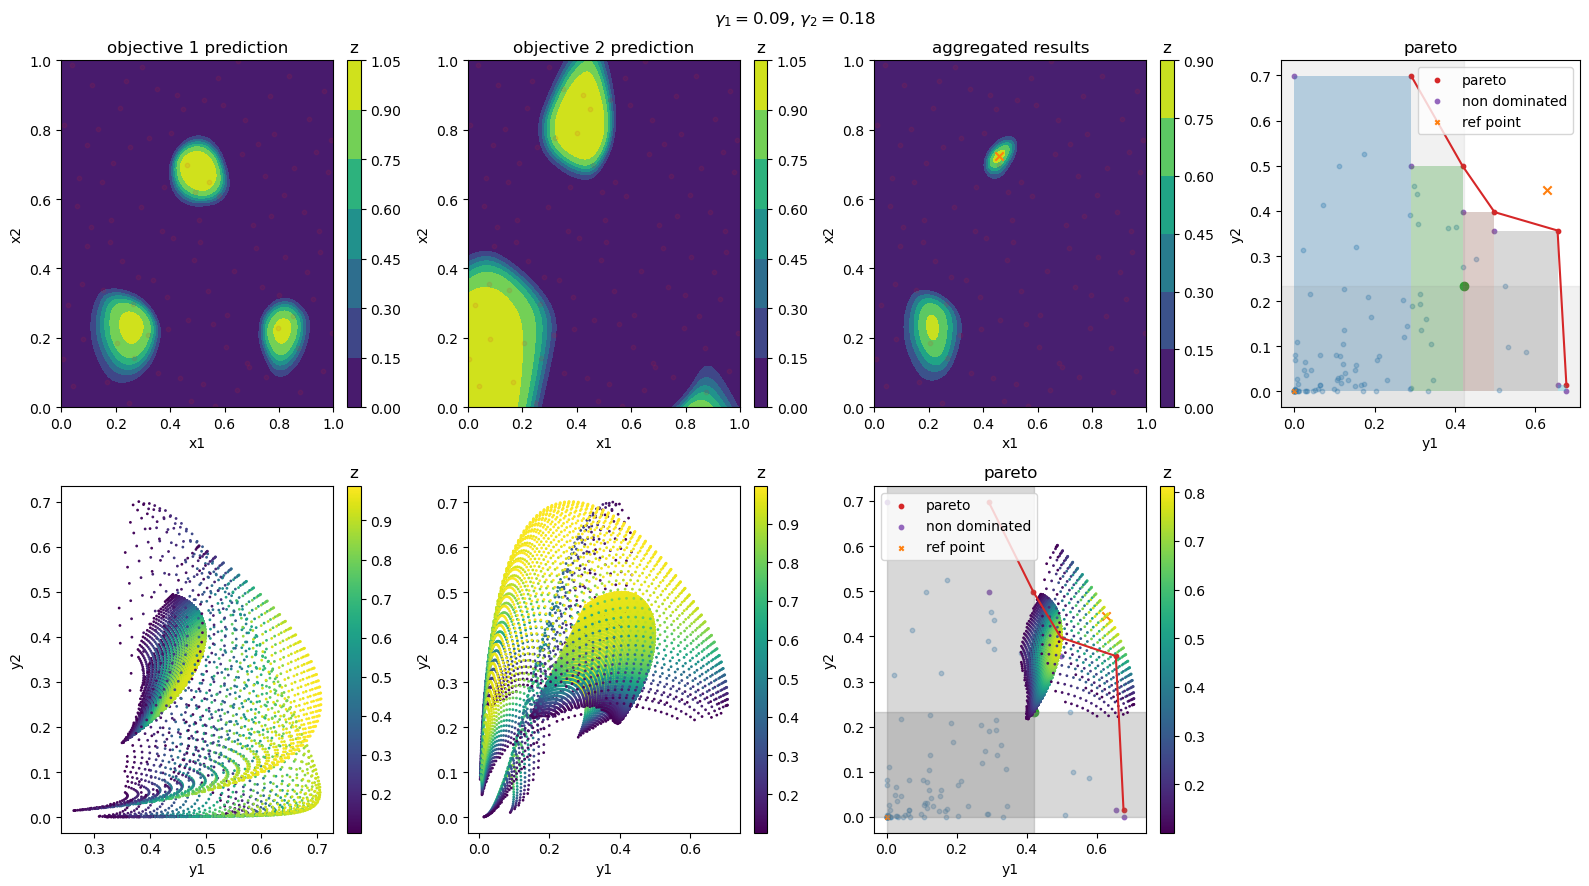

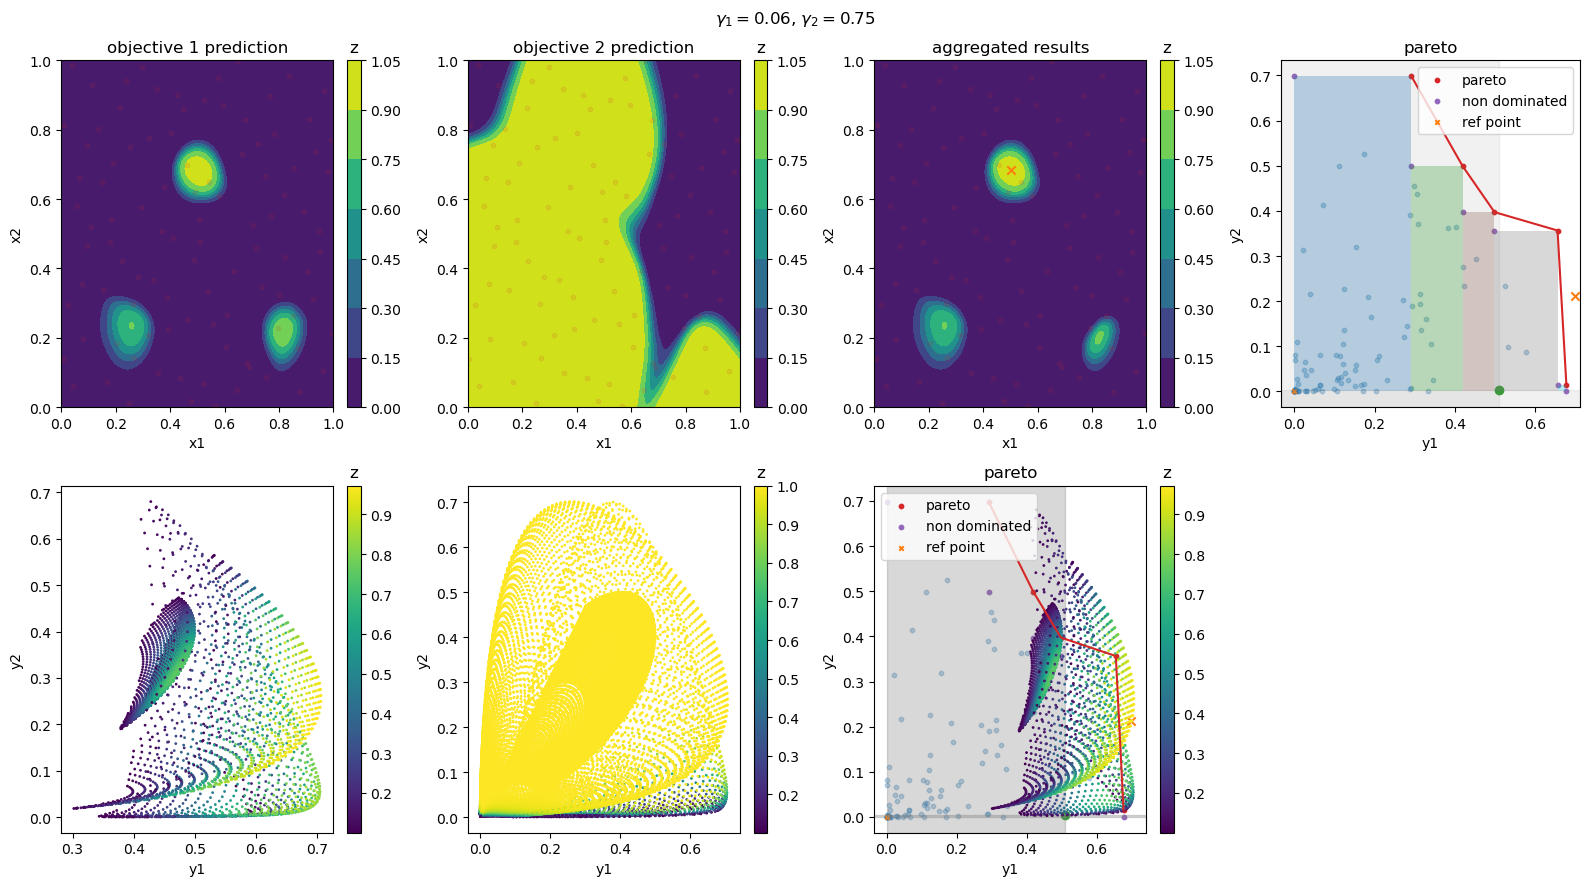

In [22]:
for n in range(1):
    print(f"Iteration {n}")

    y_shell = get_partial_observations(y_obs, 0.1, tkwargs)
    # they assumes maximization
    shell_bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_shell)
    shell_nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_shell)
    _, shell_pareto = shell_bd.hypercell_bounds
    shell_ndom, _ = shell_nbd.hypercell_bounds

    pareto = is_non_dominated(y_obs)
    bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    u, l = bd.hypercell_bounds
    u_nbd, _ = nbd.hypercell_bounds

    boxes = [Rectangle(
        l_point.cpu(),
        *(u_point - l_point).cpu(),
    ) for l_point, u_point in zip(l, u)]

    for ref in shell_pareto:
    # for ref in y_obs.numpy()[ndf[shell_idx]]:
        gamma_list = []
        tau = torch.empty(0, **tkwargs)
        for i in range(ref.shape[-1]):
            gamma = ((y_obs[:, i] >= ref[i]).sum() / len(y_obs)).to(**tkwargs)
            gamma_list.append(gamma)
            new_tau = -torch.quantile(-y_obs[:, i], q=gamma, interpolation='lower').unsqueeze(0)
            tau = torch.cat((tau, new_tau))

        fig = plt.figure(figsize=(4* (num_obj + 2), 9))

        preds = torch.empty((0, x_cands.shape[0], 1), **tkwargs)
        for i, (optimizer, gamma) in enumerate(zip(optimizer_list, gamma_list)):
            with torch.no_grad():
                preds_per_obj = optimizer.predict(x_cands, gamma=gamma)

            preds = torch.concat([preds, preds_per_obj.unsqueeze(0)], dim=0)

            ax = plt.subplot2grid((2, num_obj + 2), (0, i))
            plot_input_space(xx, yy, x_obs, preds[i], fig, ax, title=f"objective {i+1} prediction")

            ax_p = plt.subplot2grid((2, num_obj + 2), (1, i))
            div = make_axes_locatable(ax_p)
            cax = div.append_axes('right', '5%', '5%')
            non_zero_index = (preds[i].ravel() > 0.1)
            sc = ax_p.scatter(xx_obj.ravel()[non_zero_index], yy_obj.ravel()[non_zero_index], c=preds[i].ravel()[non_zero_index], s=1)

            cax.grid(False)  # just to remove the warning
            clb = fig.colorbar(sc, cax=cax)
            ax_p.set_xlabel('y1')
            ax_p.set_ylabel('y2')
            clb.ax.set_title('z')

        agg_preds = torch.cumprod(preds, dim=0)[-1]
        new_x = x_cands[agg_preds.argmax()]
        new_y = problem(new_x)

        # plot aggregated results
        ax_agg = plt.subplot2grid((2, num_obj + 2), (0, 2))
        plot_input_space(xx, yy, x_obs, agg_preds, fig, ax_agg, title="aggregated results")
        ax_agg.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')

        ax_agg_p = plt.subplot2grid((2, num_obj + 2), (1, 2))
        plot_pareto_space(y_obs, pareto, l, u_nbd, ax_agg_p, title='pareto')
        ax_agg_p.scatter(*tau.t(), label=r"$\mathbf{\tau}$")
        x_lim = ax.get_xlim()
        y_lim = ax.get_ylim()
        ax_agg_p.axvspan(x_lim[0], tau[0], alpha=0.3, color='tab:gray')
        ax_agg_p.axhspan(y_lim[0], tau[1], alpha=0.3, color='tab:gray')
        ax_agg_p.scatter(*new_y.cpu().t(), marker='x', color='tab:orange')
        non_zero_index = (agg_preds.ravel() > 0.1)
        sc = ax_agg_p.scatter(xx_obj.ravel()[non_zero_index], yy_obj.ravel()[non_zero_index], c=agg_preds.ravel()[non_zero_index], s=1)
        div = make_axes_locatable(ax_agg_p)
        cax = div.append_axes('right', '5%', '5%')

        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(sc, cax=cax)
        ax_agg_p.set_xlabel('y1')
        ax_agg_p.set_ylabel('y2')
        clb.ax.set_title('z')

        # plot pareto results
        ax_pareto = plt.subplot2grid((2, num_obj + 2), (0, 3))
        plot_pareto_space(y_obs, pareto, l, u_nbd, ax_pareto, title='pareto')
        plot_pareto_box(tau, boxes, ax_pareto)
        ax_pareto.scatter(*new_y.cpu().t(), marker='x', color='tab:orange')
        
        fig.suptitle(rf"$\gamma_1={gamma_list[0]:.2f}$, $\gamma_2={gamma_list[1]:.2f}$")
        plt.tight_layout()
        plt.show()

Iteration 0


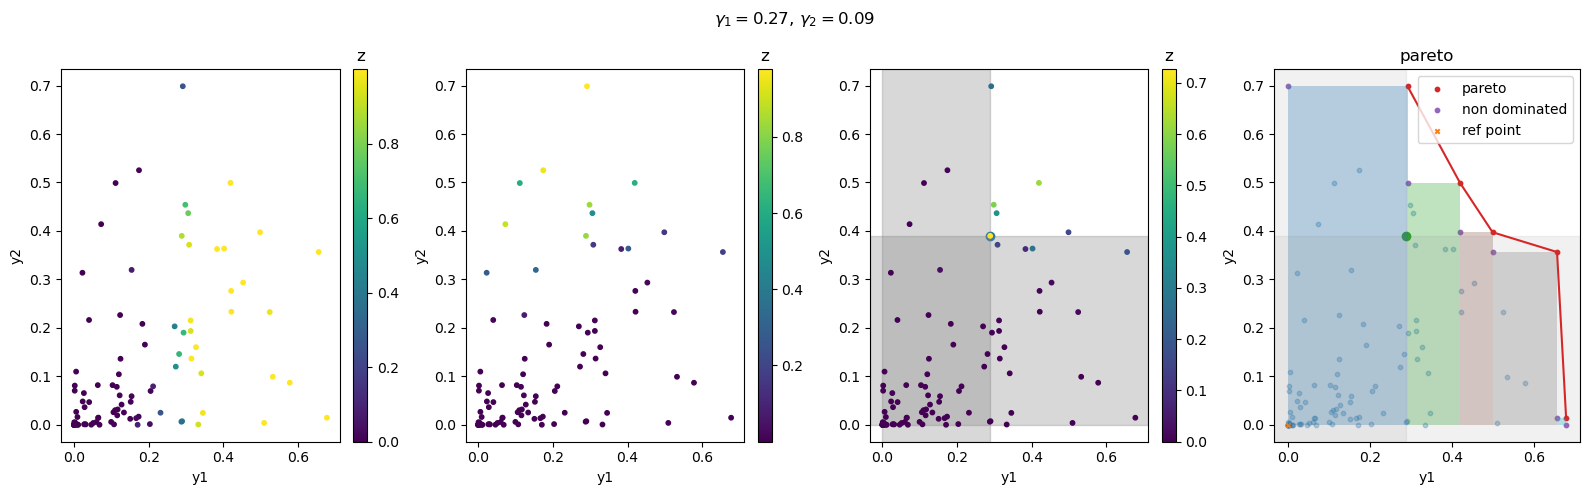

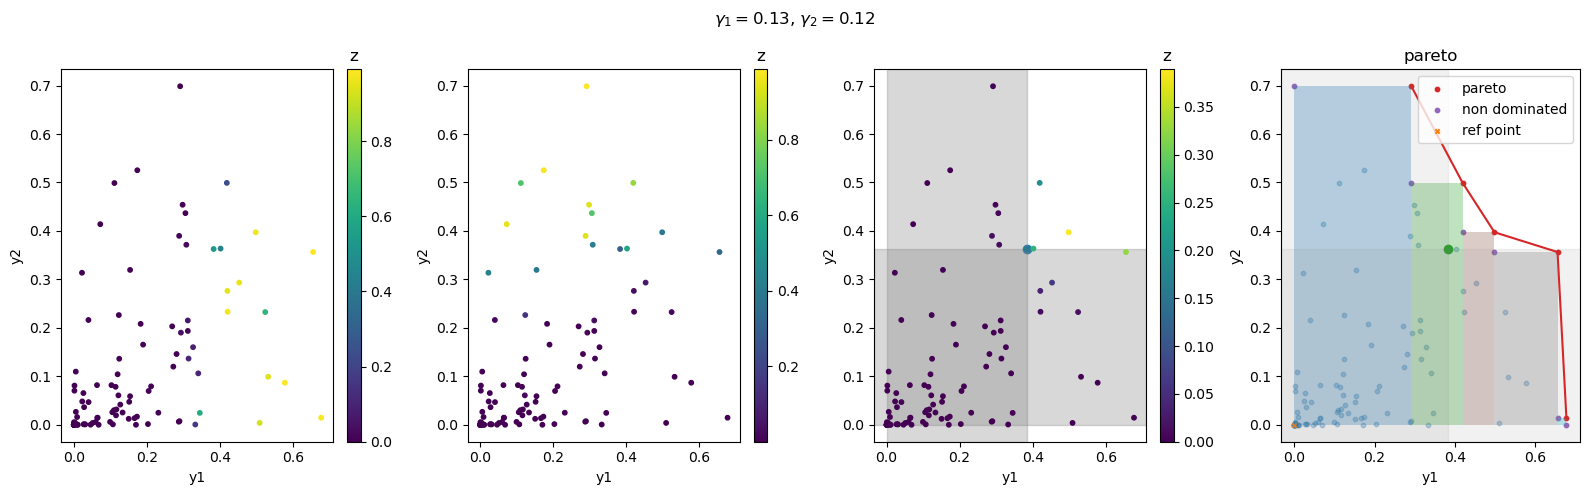

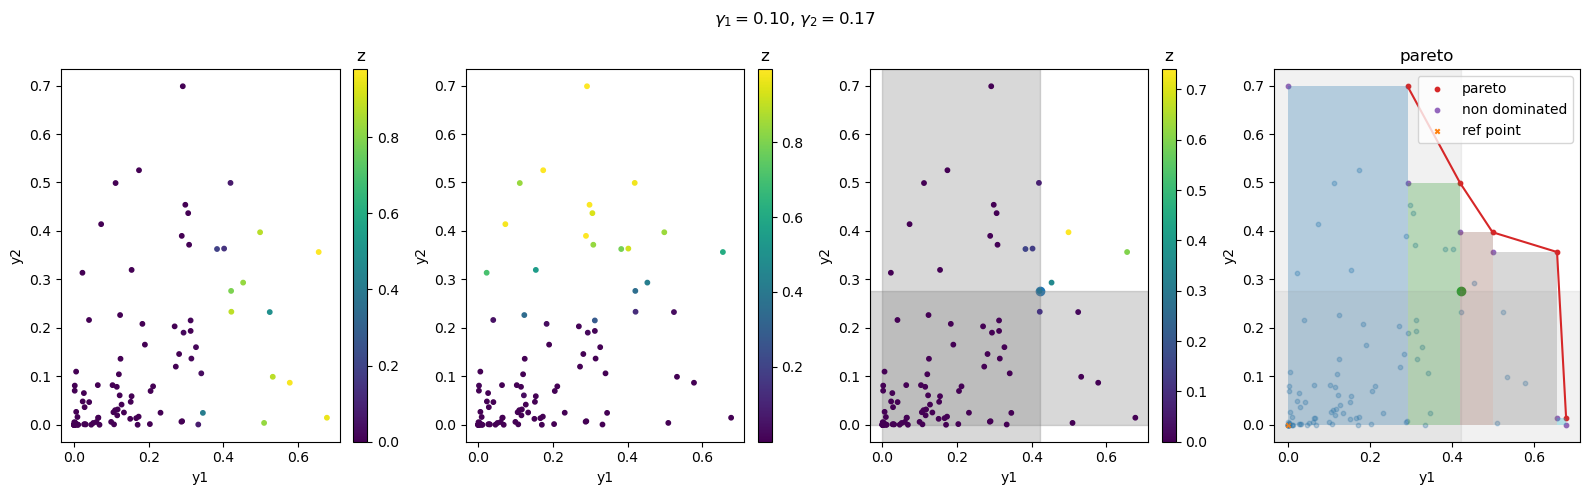

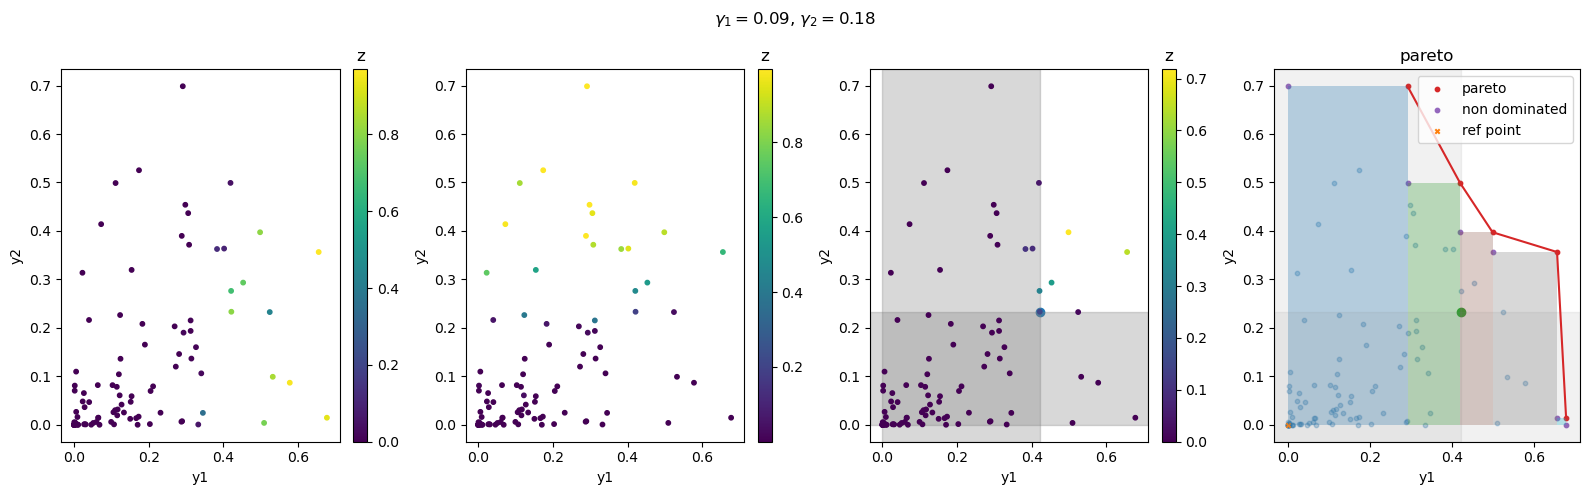

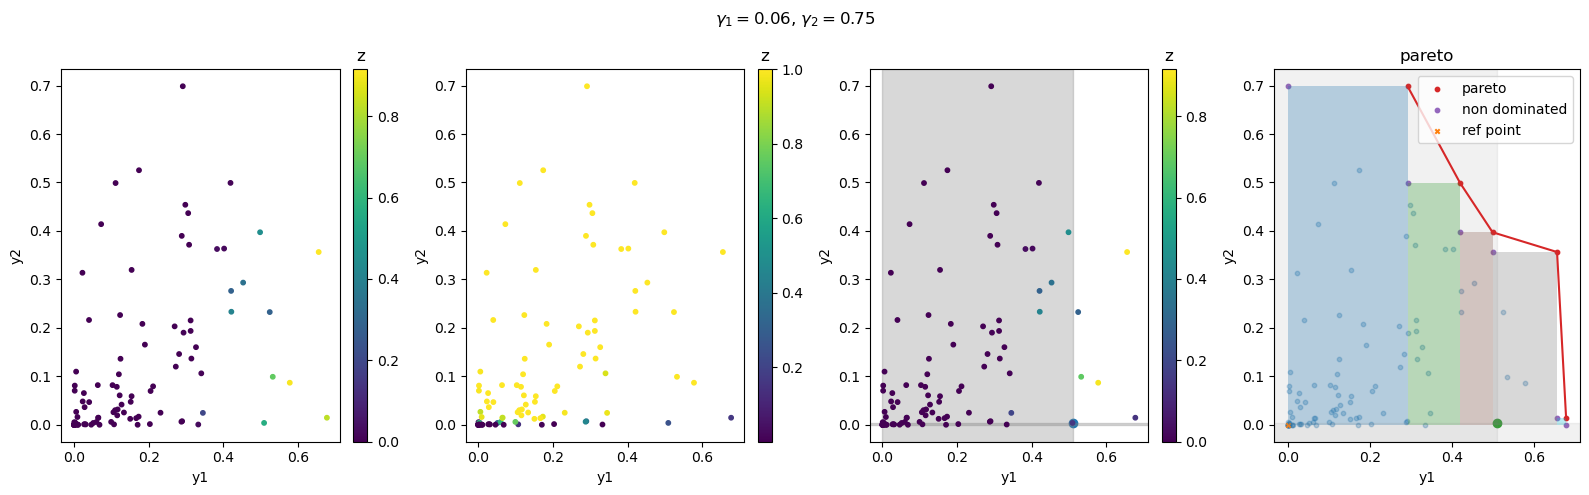

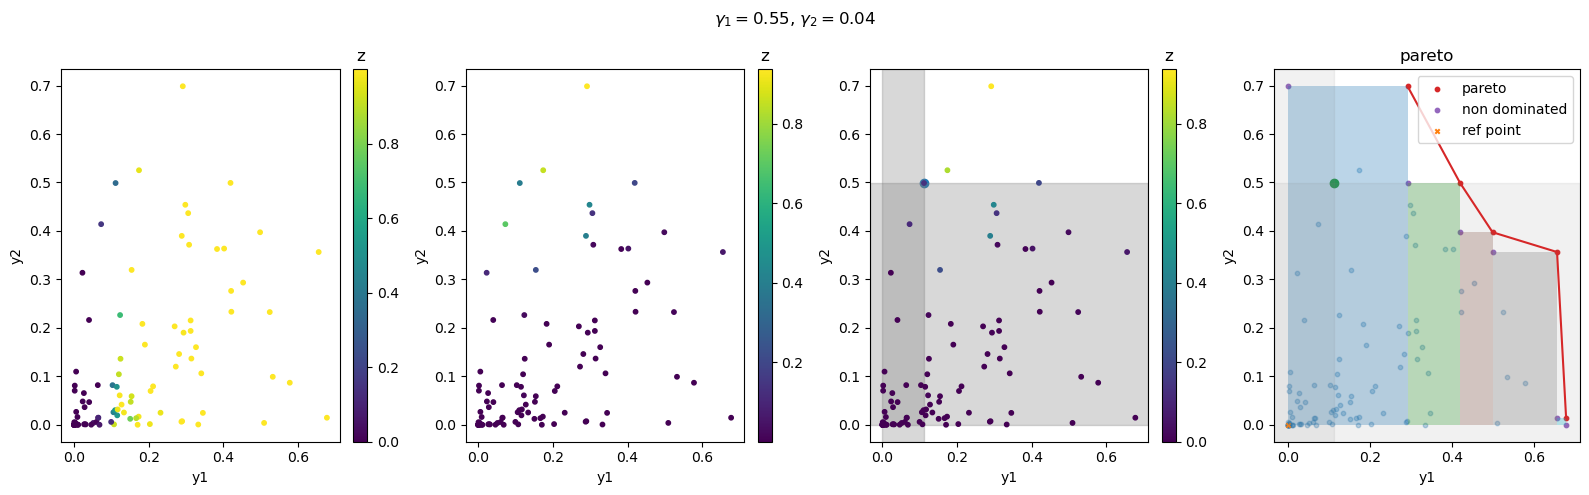

In [16]:
for n in range(1):
    print(f"Iteration {n}")
    pareto = is_non_dominated(y_obs)
    bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)

    u, l = bd.hypercell_bounds
    u_nbd, _ = nbd.hypercell_bounds

    boxes = [Rectangle(
        l_point.cpu(),
        *(u_point - l_point).cpu(),
    ) for l_point, u_point in zip(l, u)]

    # for ref in u_nbd:
    for ref in y_obs.numpy()[ndf[shell_idx]]:
        gamma_list = []
        tau = torch.empty(0, **tkwargs)
        for i in range(ref.shape[-1]):
            gamma = ((y_obs[:, i] >= ref[i]).sum() / len(y_obs)).to(**tkwargs)
            gamma_list.append(gamma)
            new_tau = -torch.quantile(-y_obs[:, i], q=gamma, interpolation='lower').unsqueeze(0)
            tau = torch.cat((tau, new_tau))

        fig = plt.figure(figsize=(4* (num_obj + 2), 5))

        preds = torch.empty((0, x_obs.shape[0], 1), **tkwargs)
        for i, (optimizer, gamma) in enumerate(zip(optimizer_list, gamma_list)):
            with torch.no_grad():
                preds_per_obj = optimizer.predict(x_obs, gamma=gamma)

            preds = torch.concat([preds, preds_per_obj.unsqueeze(0)], dim=0)

            ax_p = plt.subplot2grid((1, num_obj + 2), (0, i))
            div = make_axes_locatable(ax_p)
            cax = div.append_axes('right', '5%', '5%')
            sc = ax_p.scatter(y_obs[:, 0], y_obs[:, 1], c=preds_per_obj, s=10)

            cax.grid(False)  # just to remove the warning
            clb = fig.colorbar(sc, cax=cax)
            ax_p.set_xlabel('y1')
            ax_p.set_ylabel('y2')
            clb.ax.set_title('z')

        agg_preds = torch.cumprod(preds, dim=0)[-1]

        # plot aggregated results
        ax_agg_p = plt.subplot2grid((1, num_obj + 2), (0, 2))
        ax_agg_p.scatter(*tau.t(), label=r"$\mathbf{\tau}$")
        x_lim = ax.get_xlim()
        y_lim = ax.get_ylim()
        ax_agg_p.axvspan(x_lim[0], tau[0], alpha=0.3, color='tab:gray')
        ax_agg_p.axhspan(y_lim[0], tau[1], alpha=0.3, color='tab:gray')
        sc = ax_agg_p.scatter(y_obs[:, 0], y_obs[:, 1], c=agg_preds, s=10)
        div = make_axes_locatable(ax_agg_p)
        cax = div.append_axes('right', '5%', '5%')

        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(sc, cax=cax)
        ax_agg_p.set_xlabel('y1')
        ax_agg_p.set_ylabel('y2')
        clb.ax.set_title('z')

        # plot pareto results
        ax_pareto = plt.subplot2grid((1, num_obj + 2), (0, 3))
        plot_pareto_space(y_obs, pareto, l, u_nbd, ax_pareto, title='pareto')
        plot_pareto_box(tau, boxes, ax_pareto)
        
        fig.suptitle(rf"$\gamma_1={gamma_list[0]:.2f}$, $\gamma_2={gamma_list[1]:.2f}$")
        plt.tight_layout()
        plt.show()

In [17]:
# x_test, y_test = generate_initial_data(problem, n=6)

# for n in range(1):
#     print(f"Iteration {n}")
#     pareto = is_non_dominated(y_obs)
#     bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
#     nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)

#     u, l = bd.hypercell_bounds
#     u_nbd, _ = nbd.hypercell_bounds

#     boxes = [Rectangle(
#         l_point.cpu(),
#         *(u_point - l_point).cpu(),
#     ) for l_point, u_point in zip(l, u)]

#     for ref in u_nbd:
#         gamma_list = []
#         tau = torch.empty(0, **tkwargs)
#         for i in range(ref.shape[-1]):
#             gamma = ((y_obs[:, i] >= ref[i]).sum() / len(y_obs)).to(**tkwargs)
#             gamma_list.append(gamma)
#             new_tau = -torch.quantile(-y_obs[:, i], q=gamma, interpolation='lower').unsqueeze(0)
#             tau = torch.cat((tau, new_tau))

#         fig = plt.figure(figsize=(4* (num_obj + 2), 4))

#         preds = torch.empty((0, x_cands.shape[0], 1), **tkwargs)
#         for i, (optimizer, gamma) in enumerate(zip(optimizer_list, gamma_list)):
#             ax = plt.subplot2grid((1, num_obj + 2), (0, i))
#             div = make_axes_locatable(ax)
#             cax = div.append_axes('right', '5%', '5%')

#             with torch.no_grad():
#                 preds = torch.concat([preds, optimizer.predict(x_cands, gamma=gamma).unsqueeze(0)], dim=0)
#             # plot functions
#             countourset = ax.contourf(
#                 xx,
#                 yy,
#                 preds[i].reshape(xx.shape),
#             )
#             ax.scatter(*x_obs.t(), alpha=0.1, s=10, color='tab:red')

#             cax.grid(False)  # just to remove the warning
#             clb = fig.colorbar(countourset, cax=cax)
#             ax.set_xlabel('x')
#             ax.set_ylabel('y')
#             ax.set_title(f"objective {i+1}")
#             clb.ax.set_title('z')

#         agg_preds = torch.cumprod(preds, dim=0)[-1]
#         new_x = x_cands[agg_preds.argmax()]
#         new_y = problem(new_x)

#         # plot aggregated results
#         ax_agg = plt.subplot2grid((1, num_obj + 2), (0, 2))
#         div = make_axes_locatable(ax_agg)
#         cax = div.append_axes('right', '5%', '5%')
#         countourset = ax_agg.contourf(
#             xx,
#             yy,
#             agg_preds.reshape(xx.shape),
#         )
#         cax.grid(False)  # just to remove the warning
#         clb = fig.colorbar(countourset, cax=cax)
#         ax_agg.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
#         ax_agg.scatter(*x_obs.t(), alpha=0.1, s=10, color='tab:red')
#         ax_agg.set_xlabel('x')
#         ax_agg.set_ylabel('')
#         ax_agg.set_title(f"aggregated results")
#         clb.ax.set_title('z')

#         # plot pareto results
#         ax_pareto = plt.subplot2grid((1, num_obj + 2), (0, 3))
#         ax_pareto.scatter(*y_obs[~pareto].cpu().t(), s=10, alpha=0.3)
#         ax_pareto.scatter(*tau.t(), label=r"$\mathbf{\tau}$")
#         ax_pareto.scatter(*l.cpu().t(), s=10, color='tab:red', label="pareto")
#         ax_pareto.plot(*l.cpu().t(), color='tab:red')
#         pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
#         pc.set_array(torch.arange(0, len(l)))
#         ax_pareto.add_collection(pc)
#         ax_pareto.scatter(*problem.ref_point.cpu().t(), marker='x', s=10, label="ref point")
#         ax_pareto.scatter(*u_nbd.cpu().t(), s=10, label="non dominated", color='tab:purple')
#         ax_pareto.scatter(*new_y.cpu().t(), marker='x', color='tab:orange')

#         x_lim = ax_pareto.get_xlim()
#         y_lim = ax_pareto.get_ylim()
#         ax_pareto.axvspan(x_lim[0], tau[0], alpha=0.1, color='tab:gray')
#         ax_pareto.axhspan(y_lim[0], tau[1], alpha=0.1, color='tab:gray')
#         ax_pareto.set_xlim(*x_lim)
#         ax_pareto.set_ylim(*y_lim)
#         ax_pareto.set_xlabel('y1')
#         ax_pareto.set_ylabel('y2')
#         ax_pareto.set_title('pareto')
#         ax_pareto.legend()
        
#         fig.suptitle(rf"$\gamma_1={gamma_list[0]:.2f}$, $\gamma_2={gamma_list[1]:.2f}$")
#         plt.tight_layout()
#         plt.show()

In [18]:
# for n in range(1):
#     print(f"Iteration {n}")
#     pareto = is_non_dominated(y_obs)
#     bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
#     nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)

#     u, l = bd.hypercell_bounds
#     u_nbd, _ = nbd.hypercell_bounds

#     boxes = [Rectangle(
#         l_point.cpu(),
#         *(u_point - l_point).cpu(),
#     ) for l_point, u_point in zip(l, u)]

#     for ref in u_nbd:
#         gamma_list = []
#         tau = torch.empty(0, **tkwargs)
#         for i in range(ref.shape[-1]):
#             gamma = ((y_obs[:, i] >= ref[i]).sum() / len(y_obs)).to(**tkwargs)
#             gamma_list.append(gamma)
#             new_tau = -torch.quantile(-y_obs[:, i], q=gamma, interpolation='lower').unsqueeze(0)
#             tau = torch.cat((tau, new_tau))

#         fig = plt.figure(figsize=(4* (num_obj + 2), 4))

#         preds = torch.empty((0, x_cands.shape[0], 1), **tkwargs)
#         for i, (optimizer, gamma) in enumerate(zip(optimizer_list, gamma_list)):
#             ax = plt.subplot2grid((1, num_obj + 2), (0, i))
#             div = make_axes_locatable(ax)
#             cax = div.append_axes('right', '5%', '5%')

#             with torch.no_grad():
#                 preds = torch.concat([preds, optimizer.predict(x_cands, gamma=gamma).unsqueeze(0)], dim=0)
#             # plot functions
#             countourset = ax.contourf(
#                 xx,
#                 yy,
#                 preds[i].reshape(xx.shape),
#             )
#             ax.scatter(*x_obs.t(), alpha=0.1, s=10, color='tab:red')

#             cax.grid(False)  # just to remove the warning
#             clb = fig.colorbar(countourset, cax=cax)
#             ax.set_xlabel('x')
#             ax.set_ylabel('y')
#             ax.set_title(f"objective {i+1}")
#             clb.ax.set_title('z')

#         agg_preds = torch.cumprod(preds, dim=0)[-1]
#         new_x = x_cands[agg_preds.argmax()]
#         new_y = problem(new_x)

#         # plot aggregated results
#         ax_agg = plt.subplot2grid((1, num_obj + 2), (0, 2))
#         div = make_axes_locatable(ax_agg)
#         cax = div.append_axes('right', '5%', '5%')
#         countourset = ax_agg.contourf(
#             xx,
#             yy,
#             agg_preds.reshape(xx.shape),
#         )
#         cax.grid(False)  # just to remove the warning
#         clb = fig.colorbar(countourset, cax=cax)
#         ax_agg.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
#         ax_agg.scatter(*x_obs.t(), alpha=0.1, s=10, color='tab:red')
#         ax_agg.set_xlabel('x1')
#         ax_agg.set_ylabel('x2')
#         ax_agg.set_title(f"aggregated results")
#         clb.ax.set_title('z')

#         # plot pareto results
#         ax_pareto = plt.subplot2grid((1, num_obj + 2), (0, 3))
#         ax_pareto.scatter(*y_obs[~pareto].cpu().t(), s=10, alpha=0.3)
#         ax_pareto.scatter(*tau.t(), label=r"$\mathbf{\tau}$")
#         ax_pareto.scatter(*l.cpu().t(), s=10, color='tab:red', label="pareto")
#         ax_pareto.plot(*l.cpu().t(), color='tab:red')
#         pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
#         pc.set_array(torch.arange(0, len(l)))
#         ax_pareto.add_collection(pc)
#         ax_pareto.scatter(*problem.ref_point.cpu().t(), marker='x', s=10, label="ref point")
#         ax_pareto.scatter(*u_nbd.cpu().t(), s=10, label="non dominated", color='tab:purple')
#         ax_pareto.scatter(*new_y.cpu().t(), marker='x', color='tab:orange')

#         x_lim = ax_pareto.get_xlim()
#         y_lim = ax_pareto.get_ylim()
#         ax_pareto.axvspan(x_lim[0], tau[0], alpha=0.1, color='tab:gray')
#         ax_pareto.axhspan(y_lim[0], tau[1], alpha=0.1, color='tab:gray')
#         ax_pareto.set_xlim(*x_lim)
#         ax_pareto.set_ylim(*y_lim)
#         ax_pareto.set_xlabel('y1')
#         ax_pareto.set_ylabel('y2')
#         ax_pareto.set_title('pareto')
#         ax_pareto.legend()
        
#         fig.suptitle(rf"$\gamma_1={gamma_list[0]:.2f}$, $\gamma_2={gamma_list[1]:.2f}$")
#         plt.tight_layout()
#         plt.show()

In [19]:
# x_cands = input_data
# y_cands = problem(input_data)

# for n in range(1):
#     print(f"Iteration {n}")
#     pareto = is_non_dominated(y_obs)
#     bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
#     nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)

#     u, l = bd.hypercell_bounds
#     u_nbd, _ = nbd.hypercell_bounds

#     boxes = [Rectangle(
#         l_point.cpu(),
#         *(u_point - l_point).cpu(),
#     ) for l_point, u_point in zip(l, u)]

#     for ref in u_nbd:
#         gamma_list = []
#         tau = torch.empty(0, **tkwargs)
#         for i in range(ref.shape[-1]):
#             gamma = ((y_obs[:, i] >= ref[i]).sum() / len(y_obs)).to(**tkwargs)
#             gamma_list.append(gamma)
#             new_tau = -torch.quantile(-y_obs[:, i], q=gamma, interpolation='lower').unsqueeze(0)
#             tau = torch.cat((tau, new_tau))

#         fig = plt.figure(figsize=(4* (num_obj + 2), 4))

#         preds = torch.empty((0, x_cands.shape[0], 1), **tkwargs)
#         for i, (optimizer, gamma) in enumerate(zip(optimizer_list, gamma_list)):
#             ax = plt.subplot2grid((1, num_obj + 2), (0, i))
#             div = make_axes_locatable(ax)
#             cax = div.append_axes('right', '5%', '5%')

#             with torch.no_grad():
#                 preds = torch.concat([preds, optimizer.predict(x_cands, gamma=gamma).unsqueeze(0)], dim=0)
#             # plot functions
#             countourset = ax.contourf(
#                 xx,
#                 yy,
#                 preds[i].reshape(xx.shape),
#             )
#             ax.scatter(*x_obs.t(), alpha=0.1, s=10, color='tab:red')

#             cax.grid(False)  # just to remove the warning
#             clb = fig.colorbar(countourset, cax=cax)
#             ax.set_xlabel('x')
#             ax.set_ylabel('y')
#             ax.set_title(f"objective {i+1}")
#             clb.ax.set_title('z')

#         agg_preds = torch.cumprod(preds, dim=0)[-1]
#         new_x = x_cands[agg_preds.argmax()]
#         new_y = problem(new_x)

#         # plot aggregated results
#         ax_agg = plt.subplot2grid((1, num_obj + 2), (0, 2))
#         div = make_axes_locatable(ax_agg)
#         cax = div.append_axes('right', '5%', '5%')
#         countourset = ax_agg.contourf(
#             xx,
#             yy,
#             agg_preds.reshape(xx.shape),
#         )
#         cax.grid(False)  # just to remove the warning
#         clb = fig.colorbar(countourset, cax=cax)
#         ax_agg.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
#         ax_agg.scatter(*x_obs.t(), alpha=0.1, s=10, color='tab:red')
#         ax_agg.set_xlabel('x')
#         ax_agg.set_ylabel('y')
#         ax_agg.set_title(f"aggregated results")
#         clb.ax.set_title('z')

#         # plot pareto results
#         ax_pareto = plt.subplot2grid((1, num_obj + 2), (0, 3))
#         ax_pareto.scatter(*y_obs[~pareto].cpu().t(), s=10, alpha=0.3)
#         ax_pareto.scatter(*tau.t(), label=r"$\mathbf{\tau}$")
#         ax_pareto.scatter(*l.cpu().t(), s=10, color='tab:red', label="pareto")
#         ax_pareto.plot(*l.cpu().t(), color='tab:red')
#         pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
#         pc.set_array(torch.arange(0, len(l)))
#         ax_pareto.add_collection(pc)
#         ax_pareto.scatter(*problem.ref_point.cpu().t(), marker='x', s=10, label="ref point")
#         ax_pareto.scatter(*u_nbd.cpu().t(), s=10, label="non dominated", color='tab:purple')
#         ax_pareto.scatter(*new_y.cpu().t(), marker='x', color='tab:orange')

#         x_lim = ax_pareto.get_xlim()
#         y_lim = ax_pareto.get_ylim()
#         ax_pareto.axvspan(x_lim[0], tau[0], alpha=0.1, color='tab:gray')
#         ax_pareto.axhspan(y_lim[0], tau[1], alpha=0.1, color='tab:gray')
#         ax_pareto.set_xlim(*x_lim)
#         ax_pareto.set_ylim(*y_lim)
#         ax_pareto.set_xlabel('y1')
#         ax_pareto.set_ylabel('y2')
#         ax_pareto.set_title('pareto')
#         ax_pareto.legend()
        
#         fig.suptitle(rf"$\gamma_1={gamma_list[0]:.2f}$, $\gamma_2={gamma_list[1]:.2f}$")
#         plt.tight_layout()
#         plt.show()

In [20]:
# pi_all = []
# for n in range(1):
#     print(f"Iteration {n}")
#     pareto = is_non_dominated(y_obs)
#     bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
#     nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)

#     u, l = bd.hypercell_bounds
#     u_nbd, _ = nbd.hypercell_bounds

#     boxes = [Rectangle(
#         l_point.cpu(),
#         *(u_point - l_point).cpu(),
#     ) for l_point, u_point in zip(l, u)]

#     for i, lower in enumerate(l):
#         upper = u_nbd[i]
#         gamma_l_1 = ((y_obs[:, 0] >= lower[0]).sum() / len(y_obs)).to(**tkwargs)
#         gamma_l_2 = ((y_obs[:, 1] >= lower[1]).sum() / len(y_obs)).to(**tkwargs)
#         gamma_u_1 = ((y_obs[:, 0] >= upper[0]).sum() / len(y_obs)).to(**tkwargs)
#         gamma_u_2 = ((y_obs[:, 1] >= upper[1]).sum() / len(y_obs)).to(**tkwargs)

#         fig = plt.figure(figsize=(8, 4))
#         optimizers = [optimizer_obj_1, optimizer_obj_2]
#         gamma_l = [gamma_l_1, gamma_l_2]
#         gamma_u = [gamma_u_1, gamma_u_2]

#         pi_l = 1.
#         for i, (optimizer, gamma) in enumerate(zip(optimizers, gamma_l)):
#             pi_l *= optimizer.predict(input_data, gamma=gamma)

#         pi_u = 1.
#         for i, (optimizer, gamma) in enumerate(zip(optimizers, gamma_u)):
#             pi_u *= optimizer.predict(input_data, gamma=gamma)

#         ax_agg = plt.subplot2grid((1, 2), (0, 0))
#         div = make_axes_locatable(ax_agg)
#         cax = div.append_axes('right', '5%', '5%')
#         pi_per_region = pi_u - pi_l
#         pi_all.append(pi_per_region)
#         vals, inds = torch.topk(pi_per_region.squeeze(), k=3)
#         countourset = ax_agg.contourf(
#             xx,
#             yy,
#             pi_per_region.cpu().reshape(xx.shape),
#         )
#         cax.grid(False)  # just to remove the warning
#         clb = fig.colorbar(countourset, cax=cax)
#         ax_agg.scatter(*input_data[inds].cpu().t(), marker='x', color='tab:orange', label='candidates')

#         ax_agg.set_xlabel('x')
#         ax_agg.set_ylabel('y')
#         ax_agg.set_title(f"aggregated results")
#         clb.ax.set_title('z')

#         # plot pareto results
#         ax_pareto = plt.subplot2grid((1, 2), (0, 1))
#         ax_pareto.scatter(*y_obs[~pareto].cpu().t(), s=10, alpha=0.3)

#         l1 = -torch.quantile(-torch.unique(y_obs[:, 0]), q=gamma_l_1, interpolation='lower')
#         l2 = -torch.quantile(-torch.unique(y_obs[:, 1]), q=gamma_l_2, interpolation='lower')
#         u1 = -torch.quantile(-torch.unique(y_obs[:, 0]), q=gamma_u_1, interpolation='lower')
#         u2 = -torch.quantile(-torch.unique(y_obs[:, 1]), q=gamma_u_2, interpolation='lower')
#         ax_pareto.scatter(u1.cpu(), u2.cpu(), label=r"$\mathbf{\tau}$")

#         ax_pareto.scatter(*l.cpu().t(), s=10, color='tab:red', label="pareto")
#         ax_pareto.plot(*l.cpu().t(), color='tab:red')

#         pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
#         pc.set_array(torch.arange(0, len(l)))
#         ax_pareto.add_collection(pc)

#         ax_pareto.scatter(*problem.ref_point.cpu().t(), marker='x', s=10, label="ref point")
#         ax_pareto.scatter(*u_nbd.cpu().t(), s=10, label="non dominated", color='tab:purple')

#         y_cand = problem(input_data[inds])
#         ax_pareto.scatter(*y_cand.cpu().t(), marker='x', color='tab:orange')

#         x_lim = ax_pareto.get_xlim()
#         y_lim = ax_pareto.get_ylim()
#         ax_pareto.axhspan(y_lim[0], u2.cpu(), alpha=0.2, color='tab:gray')
#         ax_pareto.axvspan(x_lim[0], u1.cpu(), alpha=0.2, color='tab:gray')
#         ax_pareto.axvspan(l1.cpu(), x_lim[1], alpha=0.2, color='tab:gray')
#         ax_pareto.set_xlim(*x_lim)
#         ax_pareto.set_ylim(*y_lim)

#         ax_pareto.set_xlabel('y1')
#         ax_pareto.set_ylabel('y2')
#         ax_pareto.set_title('pareto')
#         ax_pareto.legend()
        
#         fig.suptitle(rf"$\gamma_1={gamma_1:.2f}$, $\gamma_2={gamma_2:.2f}$")
#         plt.tight_layout()
#         plt.show()

In [21]:
# fig = plt.figure(figsize=(8, 4))
# ax_agg = plt.subplot2grid((1, 2), (0, 0))
# div = make_axes_locatable(ax_agg)
# cax = div.append_axes('right', '5%', '5%')

# pi = torch.sum(torch.stack(pi_all), dim=0)
# vals, inds = torch.topk(pi.squeeze(), k=3)
# countourset = ax_agg.contourf(
#     xx,
#     yy,
#     pi.cpu().reshape(xx.shape),
# )
# cax.grid(False)  # just to remove the warning
# clb = fig.colorbar(countourset, cax=cax)
# ax_agg.scatter(*input_data[inds].cpu().t(), marker='x', color='tab:orange', label='candidates')
# ax_agg.set_xlabel('x')
# ax_agg.set_ylabel('y')
# ax_agg.set_title(f"aggregated results")
# clb.ax.set_title('z')

# # plot pareto results
# ax_pareto = plt.subplot2grid((1, 2), (0, 1))
# ax_pareto.scatter(*y_obs[~pareto].cpu().t(), s=10, alpha=0.3)

# ax_pareto.scatter(*l.cpu().t(), s=10, color='tab:red', label="pareto")
# ax_pareto.plot(*l.cpu().t(), color='tab:red')

# pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
# pc.set_array(torch.arange(0, len(l)))
# ax_pareto.add_collection(pc)

# ax_pareto.scatter(*problem.ref_point.cpu().t(), marker='x', s=10, label="ref point")
# ax_pareto.scatter(*u_nbd.cpu().t(), s=10, label="non dominated", color='tab:purple')

# y_cand = problem(input_data[inds])
# ax_pareto.scatter(*y_cand.cpu().t(), marker='x', color='tab:orange')

# x_lim = ax_pareto.get_xlim()
# y_lim = ax_pareto.get_ylim()

# ax_pareto.set_xlim(*x_lim)
# ax_pareto.set_ylim(*y_lim)

# ax_pareto.set_xlabel('y1')
# ax_pareto.set_ylabel('y2')
# ax_pareto.set_title('pareto')
# ax_pareto.legend()

# fig.suptitle(rf"$\gamma_1={gamma_1:.2f}$, $\gamma_2={gamma_2:.2f}$")
# plt.tight_layout()
# plt.show()